# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**Ottawa** is the capital city of Canada, with a city population over a million(June 2019) and urban area of 520 km2. As a city with high quality of living, there are many people relocating to Ottawa every year. 

If a newcomer looking to open a restaurant, where would be a good place? This project will leverage the Foursquare location data to help the stakeholders to find an optimal place to open a **chinese restaurant**. 

## Data <a name="data"></a>

Data will be using in this project:
* A list of **neighbourhoods** in city of Ottawa
 * https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Ottawa
* Coordinates of the neighbourhoods will be generated using **geocoder** in python.
* Restaurant's type and location in neighborhoods will be collected by using **Foursquare API**.

### Import libraries

In [1]:
import requests
from bs4 import BeautifulSoup 
import geocoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
import folium

### Get list of neighbourhood in city of Ottawa 

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Ottawa"
page = requests.get(url)
soup = BeautifulSoup(page.content,'html.parser')

In [3]:
neighborhoodList = []
for i in range(8):
    for row in soup.find_all("div", class_="div-col columns column-width")[i].findAll("li"):
        neighborhoodList.append(row.text)

In [4]:
neighborhoodList = list(set(neighborhoodList))
ottawa_df = pd.DataFrame({"Neighbourhood": neighborhoodList})
print("There are {} neighborhoods in Ottawa, Canada".format(ottawa_df.shape[0]))
ottawa_df.head()

There are 200 neighborhoods in Ottawa, Canada


,Neighbourhood
0,Longfields
1,Town Centre (Orleans)
2,Crystal Beach
3,Queenswood Village
4,Convent Glen


### Get List of Shopping malls in Ottawa

In [5]:
url = "https://en.m.wikipedia.org/wiki/Category:Shopping_malls_in_Ottawa"
page = requests.get(url)
soup = BeautifulSoup(page.content,'html.parser')

In [6]:
shopping_list = []
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    shopping_list.append(row.text)

In [7]:
shopping_list

['Bayshore Shopping Centre',
 'Billings Bridge Shopping Centre',
 'Carlingwood Mall',
 'College Square, Ottawa',
 'Elmvale Acres Shopping Centre',
 'Fairlawn Centre',
 'Hazeldean Mall',
 'Herongate Square',
 'Lincoln Fields Shopping Centre',
 'Merivale Mall',
 "Place d'Orléans",
 'Rideau Centre',
 'St. Laurent Centre',
 'Shoppers City East',
 'South Keys Shopping Centre',
 'Westgate Shopping Centre (Ottawa)']

### Get coordinates of Center of Neighbourhoods in Ottawa, Canada

In [8]:
ottawa_address = 'Ottawa,Canada'

In [9]:
def get_coordinates(neighbourhood):
    
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighbourhood,ottawa_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
coordinates = [get_coordinates(neighbourhood) for neighbourhood in ottawa_df["Neighbourhood"].tolist() ]
coordinates_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
ottawa_df['Latitude'] = coordinates_df['Latitude']
ottawa_df['Longitude'] = coordinates_df['Longitude']
ottawa_df.head()

,Neighbourhood,Latitude,Longitude
0,Longfields,45.290941,-75.728186
1,Town Centre (Orleans),45.480480,-75.510600
2,Crystal Beach,45.343790,-75.831560
3,Queenswood Village,45.481740,-75.519000
4,Convent Glen,45.466800,-75.532630


### Using Foursquare API to get nearby venues (Top 100 venues with a radius of 800 meters)

In [1]:
# Foursquare credentials
CLIENT_ID = '---' # your Foursquare ID
CLIENT_SECRET = '---' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [12]:
LIMIT = 100
radius = 800

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
ottawa_venues = getNearbyVenues(names=ottawa_df['Neighbourhood'],
                                   latitudes=ottawa_df['Latitude'],
                                   longitudes=ottawa_df['Longitude'])

Longfields
Town Centre (Orleans)
Crystal Beach
Queenswood Village
Convent Glen
Kanata
Victory Hill
Westboro
Bel-Air Park
Downtown
Lincoln Heights
Ellwood
Queenswood Heights
Beaverbrook
Ambleside
Skyline
LeBreton Flats
Merivale Gardens
Old Ottawa South
Lindenlea
Crystal Bay
Lees Avenue
Courtland Park
Tanglewood
Tunney's Pasture
Borden Farm
Sheffield Glen
Orchard Estates
Grenfell Glen
Chaperal
Katimavik-Hazeldean
Castle Heights
Copeland Park
Pheasant Run
Carson Meadows
Gloucester Glen
Britannia Heights
Beckett Creek
Bearbrook
Carson Grove
Lower Town
Bel-Air Heights
Stonehedge
Beacon Hill
Kanata Estates
South Keys
Leitrim
Burromee
Carlington
Davidson Heights
Redwood
Braemar Park
Blackburn Hamlet
Orléans Wood
Town Centre (Kanata)
Orleans
Lynwood Village
Whitehaven
Vanier
Meadowlands
Fallingbrook
Trend Village
Heron Gate
Rocky Point
Vars
Graham Park
Strathearn
Bells Corners
Lakeside
City View
Parkwood Hills
Chatelaine Village
Cedarhill Estate
Queensway Terrace North
Centretown West
Hillsdal

In [15]:
print(ottawa_venues.shape)
ottawa_venues.head()

(3449, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Longfields,45.290941,-75.728186,Farm Boy,45.288313,-75.724564,Grocery Store
1,Longfields,45.290941,-75.728186,Phở Haven,45.292300,-75.728299,Vietnamese Restaurant
2,Longfields,45.290941,-75.728186,Nestle Toll House Cafe,45.297026,-75.733478,Bakery
3,Longfields,45.290941,-75.728186,Milano Pizzeria,45.284479,-75.724127,Pizza Place
4,Town Centre (Orleans),45.480480,-75.510600,Shenkman Arts Centre / Centre des Arts Shenkman,45.480352,-75.511153,Concert Hall


### Top 10 popular venues

In [16]:
print('Top 10 distinct venue counts are as below')
ottawa_venues[['Venue','Venue Category']].groupby('Venue Category').count().rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
Venue Category,
Coffee Shop,251
Restaurant,128
Sandwich Place,105
Pizza Place,103
Park,98
Fast Food Restaurant,92
Grocery Store,85
Pharmacy,79
Hotel,60


### Keep neighbourhood which has restaurants

In [44]:
restaurant_list = ['Restaurant','Diner','Steakhouse','BBQ','Burrito']
ottawa_venues['Restaurant_flag'] = False
for i in restaurant_list:
    print(i)
    ottawa_venues['Restaurant_flag'] = ottawa_venues['Restaurant_flag'] | ottawa_venues['Venue Category'].str.contains(i)

Restaurant
Diner
Steakhouse
BBQ
Burrito


In [45]:
ottawa_restaurant = ottawa_venues[ottawa_venues['Restaurant_flag'] == True].reset_index(drop=True)
ottawa_restaurant.head()
ottawa_restaurant.shape
len(ottawa_restaurant['Neighbourhood'].unique())

121

In [46]:
rest_counts = ottawa_restaurant[['Neighbourhood','Venue Category']].groupby(['Neighbourhood']).count().rename(columns = {'Venue Category':'Count'})\
        .sort_values(by='Count', ascending = False)
rest_counts.head()

,Count
Neighbourhood,
South Gloucester,42
Centretown,36
Cumberland Village,31
Kempark,30
Belltown,30


### Visualize restaurant counts by neighbourhoods

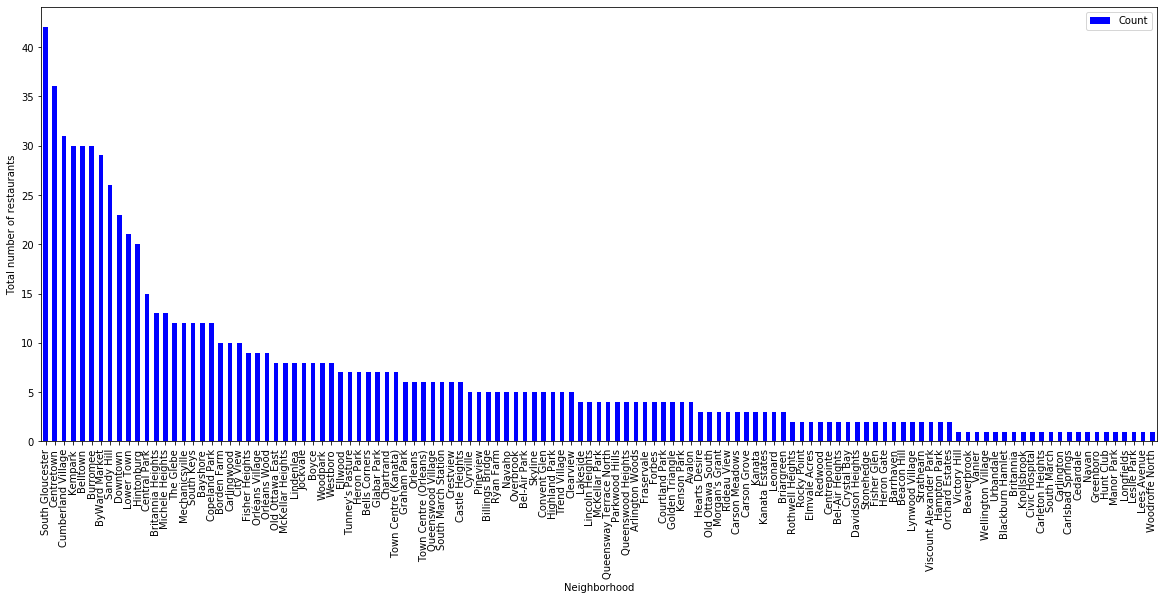

In [47]:
rest_counts.plot(kind='bar',figsize=(20,8),color='b')
#plt.title('Restaurant Counts of Neighborhoods in Ottawa')
plt.xlabel('Neighborhood')
plt.ylabel('Total number of restaurants')
plt.show()

### Only keep neighbourhoods which has no less than five resturants for further analysis

In [159]:
neighbourhood_list = list(rest_counts[rest_counts['Count'] >= 5].index)
ottawa_restaurant = ottawa_restaurant[ottawa_restaurant['Neighbourhood'].isin(neighbourhood_list)].reset_index(drop=True)
ottawa_restaurant.shape

(683, 8)

# Clustering Neighbourhoods

In [49]:
# one hot encoding
ottawa_onehot = pd.get_dummies(ottawa_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
ottawa_onehot['Neighbourhood'] = ottawa_restaurant['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [ottawa_onehot.columns[-1]] + list(ottawa_onehot.columns[:-1])
ottawa_onehot = ottawa_onehot[fixed_columns]

ottawa_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Burrito Place,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,...,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Town Centre (Orleans),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Town Centre (Orleans),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Town Centre (Orleans),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Town Centre (Orleans),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Town Centre (Orleans),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
ottawa_onehot.shape

(683, 48)

In [51]:
ottawa_grouped = ottawa_onehot.groupby('Neighbourhood').mean().reset_index()
ottawa_grouped.shape

(58, 48)

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = ottawa_grouped['Neighbourhood']

for ind in np.arange(ottawa_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ottawa_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayshore,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Indian Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Japanese Restaurant,Greek Restaurant,Gluten-free Restaurant
1,Bel-Air Park,Fast Food Restaurant,BBQ Joint,Diner,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
2,Bells Corners,American Restaurant,Asian Restaurant,Thai Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Italian Restaurant
3,Belltown,Italian Restaurant,Vietnamese Restaurant,Restaurant,Diner,Indian Restaurant,Korean Restaurant,Burrito Place,Chinese Restaurant,French Restaurant,Greek Restaurant
4,Billings Bridge,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant


In [54]:
# set number of clusters
kclusters = 5

ottawa_grouped_clustering = ottawa_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ottawa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 2, 1, 3, 1, 1, 4, 4, 3, 3, 0, 1, 1, 3, 2, 1, 3, 4, 1, 1, 3, 1,
       3, 4, 1, 0, 2, 4, 4, 3, 1, 3, 1, 3, 0, 3, 4, 2, 3, 2, 4, 4, 1, 1,
       2, 2, 3, 3, 3, 4, 1, 4, 4, 2, 0, 3, 4, 0], dtype=int32)

In [55]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ottawa_merged = ottawa_df[ottawa_df['Neighbourhood'].isin(list(set(ottawa_restaurant['Neighbourhood'])))].reset_index(drop=True)

# merge ottawa_grouped with ottawa_data to add latitude/longitude for each neighborhood
ottawa_merged = ottawa_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

ottawa_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Town Centre (Orleans),45.48048,-75.51060,2,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,French Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
1,Queenswood Village,45.48174,-75.51900,2,Fast Food Restaurant,Restaurant,French Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
2,Convent Glen,45.46680,-75.53263,4,Restaurant,Turkish Restaurant,Indian Restaurant,Steakhouse,Diner,Vietnamese Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant,Gluten-free Restaurant
3,Westboro,45.39420,-75.74915,4,Italian Restaurant,Tapas Restaurant,Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant
4,Bel-Air Park,45.35664,-75.76154,2,Fast Food Restaurant,BBQ Joint,Diner,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant


### Get Ottawa, Canada coordinates

In [56]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="ottawa_explorer")
location = geolocator.geocode(ottawa_address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ottawa are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ottawa are 45.421106, -75.690308.


In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ottawa_merged['Latitude'], ottawa_merged['Longitude'], ottawa_merged['Neighbourhood'], ottawa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 1st Most Common Venue

In [58]:
rest_top1 = ottawa_merged.groupby(['Cluster Labels','1st Most Common Venue']).count()[['Neighbourhood']].\
            reset_index().rename(columns={"Neighbourhood": "Neighbourhood Count","1st Most Common Venue": 'Most Common Venue'})
rest_top1

,Cluster Labels,Most Common Venue,Neighbourhood Count
0,0,Chinese Restaurant,3
1,0,Fast Food Restaurant,1
2,0,Vietnamese Restaurant,1
3,1,American Restaurant,1
4,1,Fast Food Restaurant,7
5,1,Italian Restaurant,1
6,1,Mexican Restaurant,3
7,1,Middle Eastern Restaurant,1
8,1,Restaurant,1
9,1,Seafood Restaurant,1


### 2nd Most Common Venue

In [59]:
rest_top2 = ottawa_merged.groupby(['Cluster Labels','2nd Most Common Venue']).count()[['Neighbourhood']].\
            reset_index().rename(columns={"Neighbourhood": "Neighbourhood Count","2nd Most Common Venue": 'Most Common Venue'})
rest_top2

,Cluster Labels,Most Common Venue,Neighbourhood Count
0,0,BBQ Joint,1
1,0,Chinese Restaurant,1
2,0,Italian Restaurant,1
3,0,Thai Restaurant,2
4,1,Asian Restaurant,3
5,1,Ethiopian Restaurant,2
6,1,Fast Food Restaurant,2
7,1,Italian Restaurant,1
8,1,Japanese Restaurant,1
9,1,Mexican Restaurant,2


### 3rd Most Common Venue

In [60]:
rest_top3 = ottawa_merged.groupby(['Cluster Labels','3rd Most Common Venue']).count()[['Neighbourhood']].\
            reset_index().rename(columns={"Neighbourhood": "Neighbourhood Count","3rd Most Common Venue": 'Most Common Venue'})
rest_top3

,Cluster Labels,Most Common Venue,Neighbourhood Count
0,0,Chinese Restaurant,1
1,0,Indian Restaurant,1
2,0,Swiss Restaurant,2
3,0,Thai Restaurant,1
4,1,American Restaurant,1
5,1,Burrito Place,1
6,1,Fast Food Restaurant,1
7,1,Italian Restaurant,1
8,1,Mexican Restaurant,3
9,1,Middle Eastern Restaurant,1


### Summarize top 3 most common venue in each cluster, counts by neighbourhoods

In [61]:
merge1 = rest_top1.merge(rest_top2, how='outer',left_on=['Cluster Labels','Most Common Venue'], right_on=['Cluster Labels','Most Common Venue'])
merge2 = merge1.merge(rest_top3, how='outer',left_on=['Cluster Labels','Most Common Venue'], right_on=['Cluster Labels','Most Common Venue'])
merge2['Total Counts'] = merge2.iloc[:,2:5].sum(axis=1)
merge_all = merge2[['Cluster Labels','Most Common Venue','Total Counts']].sort_values(by=['Cluster Labels','Total Counts'], ascending=[True,False]).reset_index(drop=True)


#### Cluster 0

In [62]:
merge_all.loc[merge_all['Cluster Labels'] == 0]

,Cluster Labels,Most Common Venue,Total Counts
0,0,Chinese Restaurant,5.0
1,0,Thai Restaurant,3.0
2,0,Swiss Restaurant,2.0
3,0,Fast Food Restaurant,1.0
4,0,Vietnamese Restaurant,1.0
5,0,BBQ Joint,1.0
6,0,Italian Restaurant,1.0
7,0,Indian Restaurant,1.0


#### Cluster 1

In [64]:
merge_all.loc[merge_all['Cluster Labels'] == 1]

,Cluster Labels,Most Common Venue,Total Counts
8,1,Fast Food Restaurant,10.0
9,1,Mexican Restaurant,8.0
10,1,Restaurant,4.0
11,1,Italian Restaurant,3.0
12,1,Seafood Restaurant,3.0
13,1,Asian Restaurant,3.0
14,1,American Restaurant,2.0
15,1,Middle Eastern Restaurant,2.0
16,1,Ethiopian Restaurant,2.0
17,1,Sushi Restaurant,2.0


#### Cluster 2

In [66]:
merge_all.loc[merge_all['Cluster Labels'] == 2]

,Cluster Labels,Most Common Venue,Total Counts
23,2,Fast Food Restaurant,8.0
24,2,Restaurant,5.0
25,2,BBQ Joint,3.0
26,2,Vietnamese Restaurant,3.0
27,2,Diner,2.0
28,2,French Restaurant,2.0
29,2,Chinese Restaurant,1.0


#### Cluster 3

In [67]:
merge_all.loc[merge_all['Cluster Labels'] == 3]

,Cluster Labels,Most Common Venue,Total Counts
30,3,Restaurant,8.0
31,3,New American Restaurant,5.0
32,3,Vietnamese Restaurant,5.0
33,3,French Restaurant,5.0
34,3,Mexican Restaurant,3.0
35,3,Asian Restaurant,3.0
36,3,Diner,3.0
37,3,Sushi Restaurant,3.0
38,3,Tapas Restaurant,3.0
39,3,Chinese Restaurant,2.0


### Cluster 4

In [68]:
merge_all.loc[merge_all['Cluster Labels'] == 4]

,Cluster Labels,Most Common Venue,Total Counts
44,4,Restaurant,12.0
45,4,Middle Eastern Restaurant,6.0
46,4,Fast Food Restaurant,3.0
47,4,American Restaurant,3.0
48,4,Indian Restaurant,3.0
49,4,Turkish Restaurant,3.0
50,4,Vietnamese Restaurant,2.0
51,4,Japanese Restaurant,2.0
52,4,Italian Restaurant,1.0
53,4,Afghan Restaurant,1.0


## Based on clustering results, recommendation:
* **Cluster 0: Chinese Restaurant, Thai Restaurant**
* **Cluster 1: Fast Food Restaurant, Mexican Restaurant, Itlian Restaurant, Seafood Restaurant, Asian Restaurant**
* **Cluster 2: Fast Food Restaurant, BBQ Joint**
* **Cluster 3: New American Restaurant, Vietnamese Restaurant, French Restaurant**
* **Cluster 4: Middle Eastern Restaurant, American Restaurant, Indian Restaurant, Turkish Restaurant**

### ~ Cluster 0 
* **Chinese Restaurant, Thai Restaurant**
* **Recommend neighbourhood: Carlingwood(near shoping center)**

In [137]:
cluster0 = ottawa_merged[ottawa_merged['Cluster Labels'] == 0]
cluster0

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Trend Village,45.32990,-75.78191,0,Vietnamese Restaurant,BBQ Joint,Chinese Restaurant,Greek Restaurant,Restaurant,Fast Food Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
28,Carlingwood,45.37620,-75.76875,0,Chinese Restaurant,Thai Restaurant,Indian Restaurant,Swiss Restaurant,Greek Restaurant,Diner,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Ethiopian Restaurant
37,Glabar Park,45.37135,-75.76372,0,Fast Food Restaurant,Chinese Restaurant,Swiss Restaurant,Greek Restaurant,Diner,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
46,McKellar Heights,45.36680,-75.76605,0,Chinese Restaurant,Thai Restaurant,Swiss Restaurant,Greek Restaurant,Diner,Fast Food Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Japanese Restaurant,Italian Restaurant
56,Woodpark,45.37120,-75.77795,0,Chinese Restaurant,Italian Restaurant,Thai Restaurant,Swiss Restaurant,Greek Restaurant,Diner,Fast Food Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Japanese Restaurant


In [138]:
rest_counts.loc[list(cluster0['Neighbourhood'])].reset_index()

,Neighbourhood,Count
0,Trend Village,5
1,Carlingwood,10
2,Glabar Park,7
3,McKellar Heights,8
4,Woodpark,8


### ~ Cluster 1 Recommend neighbourhood: Central Park, City View(surrounded by college and retail store)

In [143]:
cluster1 = ottawa_merged[ottawa_merged['Cluster Labels'] == 1]
cluster1

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Lindenlea,45.43643,-75.67290,1,Mexican Restaurant,Ethiopian Restaurant,Middle Eastern Restaurant,Italian Restaurant,Sushi Restaurant,Diner,Fast Food Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant
10,Borden Farm,45.35230,-75.73084,1,Fast Food Restaurant,Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Chinese Restaurant,Ramen Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
11,Castle Heights,45.43200,-75.64354,1,Fast Food Restaurant,Asian Restaurant,Burrito Place,Indian Restaurant,Greek Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Gluten-free Restaurant
12,Copeland Park,45.35801,-75.73971,1,Fast Food Restaurant,Asian Restaurant,Mexican Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Diner,Portuguese Restaurant,Restaurant,Italian Restaurant
22,Bells Corners,45.32278,-75.83158,1,American Restaurant,Asian Restaurant,Thai Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Italian Restaurant
23,City View,45.35141,-75.73621,1,Fast Food Restaurant,Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Chinese Restaurant,Ramen Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
25,Central Park,45.40685,-75.69055,1,Middle Eastern Restaurant,Fast Food Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Restaurant,Seafood Restaurant,Italian Restaurant
26,Cyrville,45.41680,-75.63264,1,Mexican Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Seafood Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
29,Fisher Heights,45.36680,-75.73265,1,Restaurant,Fast Food Restaurant,Mexican Restaurant,Asian Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Portuguese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
35,Pineview,45.42617,-75.61128,1,Italian Restaurant,Mongolian Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant


In [145]:
rest_counts.loc[list(cluster1['Neighbourhood'])]

,Count
Neighbourhood,
Lindenlea,8
Borden Farm,10
Castle Heights,6
Copeland Park,12
Bells Corners,7
City View,10
Central Park,15
Cyrville,5
Fisher Heights,9


### ~ Cluster 2 Recommend neighbourhood: Orleans, Town Centre (Orleans)	

In [148]:
cluster2 = ottawa_merged[ottawa_merged['Cluster Labels'] == 2]
cluster2

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Town Centre (Orleans),45.48048,-75.510600,2,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,French Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
1,Queenswood Village,45.48174,-75.519000,2,Fast Food Restaurant,Restaurant,French Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
4,Bel-Air Park,45.35664,-75.761540,2,Fast Food Restaurant,BBQ Joint,Diner,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
19,Orleans,45.48048,-75.510600,2,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,French Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
21,Graham Park,45.34320,-75.799650,2,Fast Food Restaurant,Restaurant,Chinese Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
24,Navaho,45.35145,-75.757536,2,Fast Food Restaurant,BBQ Joint,Diner,French Restaurant,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
42,Ryan Farm,45.34590,-75.755450,2,Restaurant,Fast Food Restaurant,BBQ Joint,French Restaurant,Vietnamese Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
52,Chartrand,45.47452,-75.511581,2,Fast Food Restaurant,Vietnamese Restaurant,French Restaurant,Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant


In [149]:
rest_counts.loc[list(cluster2['Neighbourhood'])]

,Count
Neighbourhood,
Town Centre (Orleans),6
Queenswood Village,6
Bel-Air Park,5
Orleans,6
Graham Park,6
Navaho,5
Ryan Farm,5
Chartrand,7


In [155]:
cluster3 = ottawa_merged[ottawa_merged['Cluster Labels'] == 3]
cluster3

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown,45.413060,-75.690070,3,Greek Restaurant,Restaurant,Seafood Restaurant,American Restaurant,Japanese Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,New American Restaurant
7,Skyline,45.363200,-75.727150,3,Restaurant,Sushi Restaurant,Diner,Portuguese Restaurant,Korean Restaurant,Vietnamese Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
9,Tunney's Pasture,45.406660,-75.735830,3,New American Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,BBQ Joint,Diner,Spanish Restaurant,Fast Food Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
14,Lower Town,45.433520,-75.684510,3,Middle Eastern Restaurant,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Korean Restaurant,BBQ Joint,German Restaurant,Chinese Restaurant,Asian Restaurant
16,Burromee,45.421780,-75.691160,3,Restaurant,Tapas Restaurant,French Restaurant,New American Restaurant,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Fast Food Restaurant,Japanese Restaurant,Greek Restaurant
30,Belltown,45.402063,-75.703244,3,Italian Restaurant,Vietnamese Restaurant,Restaurant,Diner,Indian Restaurant,Korean Restaurant,Burrito Place,Chinese Restaurant,French Restaurant,Greek Restaurant
31,Clearview,45.333400,-75.699350,3,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,New American Restaurant,Restaurant,Fast Food Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
33,Hintonburg,45.403400,-75.727950,3,New American Restaurant,Diner,Vietnamese Restaurant,Spanish Restaurant,Gluten-free Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,French Restaurant,Chinese Restaurant,Seafood Restaurant
34,Kempark,45.421780,-75.691160,3,Restaurant,Tapas Restaurant,French Restaurant,New American Restaurant,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Fast Food Restaurant,Japanese Restaurant,Greek Restaurant
47,Mechanicsville,45.406360,-75.725650,3,New American Restaurant,Diner,Asian Restaurant,Thai Restaurant,Tapas Restaurant,BBQ Joint,Indian Restaurant,Gluten-free Restaurant,Seafood Restaurant,Vietnamese Restaurant


In [156]:
rest_counts.loc[list(cluster3['Neighbourhood'])]

,Count
Neighbourhood,
Downtown,23
Skyline,5
Tunney's Pasture,7
Lower Town,21
Burromee,30
Belltown,30
Clearview,5
Hintonburg,20
Kempark,30


In [157]:
cluster4 = ottawa_merged[ottawa_merged['Cluster Labels'] == 4]
cluster4

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Convent Glen,45.466800,-75.532630,4,Restaurant,Turkish Restaurant,Indian Restaurant,Steakhouse,Diner,Vietnamese Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant,Gluten-free Restaurant
3,Westboro,45.394200,-75.749150,4,Italian Restaurant,Tapas Restaurant,Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant
6,Ellwood,45.366800,-75.666040,4,Restaurant,Afghan Restaurant,Middle Eastern Restaurant,Thai Restaurant,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant,Gluten-free Restaurant
13,Britannia Heights,45.350100,-75.799350,4,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Kebab Restaurant,Italian Restaurant,Indian Restaurant,Chinese Restaurant,Sri Lankan Restaurant,Japanese Restaurant,Greek Restaurant
15,South Keys,45.359000,-75.650740,4,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Thai Restaurant,Swiss Restaurant,English Restaurant,Indian Restaurant
17,Orléans Wood,45.466308,-75.528817,4,Restaurant,Turkish Restaurant,American Restaurant,Indian Restaurant,Steakhouse,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Japanese Restaurant
18,Town Centre (Kanata),45.315170,-75.908140,4,Vietnamese Restaurant,American Restaurant,Japanese Restaurant,Italian Restaurant,Steakhouse,German Restaurant,Restaurant,Ethiopian Restaurant,Indian Restaurant,Greek Restaurant
27,Heron Park,45.379290,-75.677460,4,Restaurant,Seafood Restaurant,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
32,Highland Park,45.382900,-75.757650,4,Middle Eastern Restaurant,Restaurant,Thai Restaurant,Steakhouse,Vietnamese Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
36,Bayshore,45.351510,-75.809780,4,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Indian Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Japanese Restaurant,Greek Restaurant,Gluten-free Restaurant


In [158]:
rest_counts.loc[list(cluster4['Neighbourhood'])]

,Count
Neighbourhood,
Convent Glen,5
Westboro,8
Ellwood,7
Britannia Heights,13
South Keys,12
Orléans Wood,9
Town Centre (Kanata),7
Heron Park,7
Highland Park,5
